# Setup

In [1]:
# data cleaning and plots
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# sklearn: data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# sklearn: train model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from sklearn.metrics import precision_recall_curve, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report

# sklearn classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Data Processing

## Load Data

In [2]:
# Load data
initial_data = pd.read_csv('../../datasets/liver/indian_liver_patient.csv')
# initial_data = pd.read_csv('../../datasets/liver/indian_liver_patient_under50.csv')
# initial_data = pd.read_csv('../../datasets/liver/indian_liver_patient_over50.csv')

In [3]:
# Look at the first 5 rows
initial_data.head(n=5)

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,2
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,2
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,2
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,2
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,2


In [4]:
# information of the data: 583 data points, 10 features' columns and 1 target column
initial_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


## Tidy Data

In [5]:
# check if there are Null values
initial_data.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [6]:
# Discard the rows with missing values
data_to_use = initial_data.dropna()

# Shape of the data: we could see that the number of rows is 579 now (originally it is 583)
data_to_use.shape

(579, 11)

In [7]:
# check if there are Null values
data_to_use.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64

In [8]:
initial_data['Dataset'].value_counts()

2    416
1    167
Name: Dataset, dtype: int64

In [9]:
X = data_to_use.drop(axis=1, columns=['Dataset']) # X is a dataframe

y = data_to_use['Dataset'].values # y is an array

In [10]:
# Calculate Y ratio
def data_ratio(y):
    '''
    Calculate Y's ratio
    '''
    unique, count = np.unique(y, return_counts=True)
    ratio = round(count[0]/count[1], 1)
    return f'{ratio}:1 ({count[0]}/{count[1]})'

The class ratio for the original data: 0.4:1 (165/414)


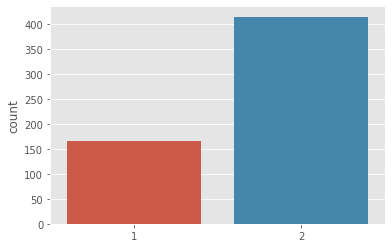

In [11]:
print('The class ratio for the original data:', data_ratio(y))
sns.countplot(y,label="Sum")
plt.show()

In [12]:
initial_data['Dataset'].value_counts()

2    416
1    167
Name: Dataset, dtype: int64

## Split Data

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [14]:
print('The class ratio in training data: ', data_ratio(y_train))
print('The class ratio in testing data: ', data_ratio(y_test))

The class ratio in training data:  0.4:1 (120/285)
The class ratio in testing data:  0.3:1 (45/129)


In [15]:
# determine categorical and numerical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object', 'bool']).columns

In [16]:
numerical_cols

Index(['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object')

In [17]:
categorical_cols

Index(['Gender'], dtype='object')

In [18]:
# define the transformation methods for the columns
t = [('ohe', OneHotEncoder(drop='first'), categorical_cols),
    ('scale', StandardScaler(), numerical_cols)]

col_trans = ColumnTransformer(transformers=t)

# fit the transformation on training data
col_trans.fit(X_train)

ColumnTransformer(transformers=[('ohe', OneHotEncoder(drop='first'),
                                 Index(['Gender'], dtype='object')),
                                ('scale', StandardScaler(),
                                 Index(['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase',
       'Alamine_Aminotransferase', 'Aspartate_Aminotransferase',
       'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio'],
      dtype='object'))])

In [19]:
# apply transformation to both training and testing data 
X_train_transform = col_trans.transform(X_train)
X_test_transform = col_trans.transform(X_test)

In [20]:
# look at the transformed training data
X_train_transform

array([[ 0.        ,  0.71404407, -0.40261392, ...,  0.47646941,
         1.11153374,  1.21117076],
       [ 1.        ,  0.09625332, -0.41888724, ...,  0.38518743,
         0.33760051, -0.13402095],
       [ 1.        , -0.89221188, -0.25615407, ..., -0.80147834,
        -0.5653216 , -0.13402095],
       ...,
       [ 0.        ,  1.8878465 , -0.3863406 , ..., -1.89686213,
        -1.46824371, -0.47031888],
       [ 1.        , -1.38644447, -0.3863406 , ...,  1.29800725,
         0.85355599, -0.13402095],
       [ 0.        ,  0.09625332,  1.79428389, ..., -1.98814412,
        -1.46824371, -0.47031888]])

In [21]:
col_trans.transformers_[0][1].get_feature_names()


array(['x0_Male'], dtype=object)

In [22]:
new_cols = ['Male'] + numerical_cols.to_list()

pd.DataFrame(X_train_transform, columns=new_cols).head()

,Male,Age,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio
0,0.0,0.714044,-0.402614,-0.507791,-0.595629,-0.327092,-0.445881,0.476469,1.111534,1.211171
1,1.0,0.096253,-0.418887,-0.467873,-0.722543,-0.409672,-0.520121,0.385187,0.337601,-0.134021
2,1.0,-0.892212,-0.256154,-0.388038,0.195468,0.072045,0.271769,-0.801478,-0.565322,-0.134021
3,0.0,-0.768654,-0.402614,-0.507791,-0.193735,-0.423435,-0.495374,0.476469,-0.178355,-0.806617
4,0.0,-1.139328,-0.370067,-0.467873,-0.557555,-0.395908,-0.513934,0.476469,0.466589,0.202277


In [23]:
# Note that the distinct values/labels in `y` target are 1 and 2. 
pd.unique(y)

array([2, 1])

In [24]:
# Define a LabelEncoder() transformation method and fit on y_train
target_trans = LabelEncoder()
target_trans.fit(y_train)

LabelEncoder()

In [25]:
# apply transformation method on y_train and y_test
y_train_transform = target_trans.transform(y_train)
y_test_transform = target_trans.transform(y_test)

In [26]:
# view the transformed y_train
y_train_transform

array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,

# Train Model

In [27]:
# ===== Step 1: cross-validation ========
# define a Logistic Regression classifier
clf = LogisticRegression(solver='lbfgs', random_state=123)

# define  Stratified 5-fold cross-validator, it provides train/validate indices to split data in train/validate sets.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

# define metrics for evaluating
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# perform the 5-fold CV and get the metrics results
cv_results = cross_validate(estimator=clf,
                            X=X_train_transform,
                            y=y_train_transform,
                            scoring=scoring,
                            cv=cv,
                            return_train_score=False) # prevent to show the train scores on cv splits.

In [28]:
cv_results

{'fit_time': array([0.00727677, 0.00685453, 0.00649643, 0.00741386, 0.006356  ]),
 'score_time': array([0.00364351, 0.0032475 , 0.00341129, 0.00323462, 0.00324821]),
 'test_accuracy': array([0.77777778, 0.74074074, 0.71604938, 0.69135802, 0.67901235]),
 'test_precision': array([0.79104478, 0.73684211, 0.74285714, 0.75      , 0.72463768]),
 'test_recall': array([0.92982456, 0.98245614, 0.9122807 , 0.84210526, 0.87719298]),
 'test_f1': array([0.85483871, 0.84210526, 0.81889764, 0.79338843, 0.79365079]),
 'test_roc_auc': array([0.77192982, 0.80628655, 0.75219298, 0.71637427, 0.75073099])}

In [29]:
cv_results['test_accuracy'].mean()

0.7209876543209877

In [30]:
for i in cv_results:
    print(i, ": ", cv_results[i].mean())

fit_time :  0.0068795204162597655
score_time :  0.0033570289611816405
test_accuracy :  0.7209876543209877
test_precision :  0.7490763410798248
test_recall :  0.9087719298245613
test_f1 :  0.8205761668066899
test_roc_auc :  0.7595029239766082


In [31]:

# ======== Step 2: Evaluate the model using testing data =======

# fit the Logistic Regression model
clf.fit(X=X_train_transform, y=y_train_transform)

# predition on testing data
y_pred_class = clf.predict(X=X_test_transform)
y_pred_score = clf.predict_proba(X=X_test_transform)[:, 1]

# AUC of ROC
auc_ontest = roc_auc_score(y_true=y_test_transform, y_score=y_pred_score)
# confusion matrix
cm_ontest = confusion_matrix(y_true=y_test_transform, y_pred=y_pred_class)
# precision score
precision_ontest = precision_score(y_true=y_test_transform, y_pred=y_pred_class)
# recall score
recall_ontest = recall_score(y_true=y_test_transform, y_pred=y_pred_class)
# classifition report
cls_report_ontest = classification_report(y_true=y_test_transform, y_pred=y_pred_class)

# print the above results
print('The model scores {:1.5f} ROC AUC on the test set.'.format(auc_ontest))
print('The precision score on the test set: {:1.5f}'.format(precision_ontest))
print('The recall score on the test set: {:1.5f}'.format(recall_ontest))
print('Confusion Matrix:\n', cm_ontest)
# Print classification report:
print('Classification Report:\n', cls_report_ontest)

The model scores 0.73402 ROC AUC on the test set.
The precision score on the test set: 0.78431
The recall score on the test set: 0.93023
Confusion Matrix:
 [[ 12  33]
 [  9 120]]
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.27      0.36        45
           1       0.78      0.93      0.85       129

    accuracy                           0.76       174
   macro avg       0.68      0.60      0.61       174
weighted avg       0.73      0.76      0.73       174

